In [23]:
import os
import numpy as np
import random
from scipy import pi
from itertools import islice
import cv2
import tensorflow as tf
import scipy.misc

In [24]:
DATA_FOLDER = 'G:/Applied AI case study/Self driving car/Autopilot-TensorFlow-master/driving_dataset/' 
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in fp:
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_ratio = int(len(X) * 0.7)

train_x = X[:split_ratio]
train_y = y[:split_ratio]

test_x = X[split_ratio:]
test_y = y[split_ratio:]

print(len(train_x), len(train_y), len(test_x), len(test_y))



Completed processing data.txt
31784 31784 13622 13622


C:\Users\abc\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


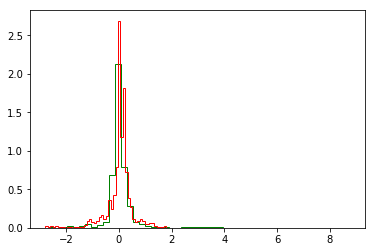

In [25]:
# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()

In [26]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )

Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


In [27]:
train_batch_pointer = 0
test_batch_pointer = 0

In [28]:
def loadTrainBatch(batch_size):
    global train_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(train_x[(train_batch_pointer + i) % len(train_x)]) 
        read_image_road = read_image[-150:] 
        read_image_resize = cv2.resize(read_image_road, (200, 66)) 
        read_image_final = read_image_resize/255.0
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(train_y[(train_batch_pointer + i) % len(train_y)]) #appending corresponding labels
        
    train_batch_pointer += batch_size
        
    return x_result, y_result

In [29]:
def loadTestBatch(batch_size):
    global test_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(test_x[(test_batch_pointer + i) % len(test_x)]) 
        read_image_road = read_image[-150:] 
        read_image_resize = cv2.resize(read_image_road, (200, 66)) 
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(test_y[(test_batch_pointer + i) % len(test_y)]) #appending corresponding labels
        
    test_batch_pointer += batch_size
        
    return x_result, y_result

In [30]:
def weightVariable(shape):
    initial = tf.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(initial) 

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2D(previous_input, filter_input, strides):
    return tf.nn.conv2d(previous_input, filter_input, strides = [1, strides, strides, 1], padding = "VALID")

In [31]:
x_input = tf.placeholder(tf.float32, shape = [None, 66, 200, 3])
y_true = tf.placeholder(tf.float32)

input_image = x_input

In [32]:

#First convolution layer
W_Conv1 = weightVariable([5,5,3,24])
B_Conv1 = bias_variable([24])
Conv1 = tf.nn.relu(conv2D(input_image, W_Conv1, 2) + B_Conv1)

#Second convolution layer
W_Conv2 = weightVariable([5,5,24,36])
B_Conv2 = bias_variable([36])
Conv2 = tf.nn.relu(conv2D(Conv1, W_Conv2, 2) + B_Conv2)


#Third convolution layer
W_Conv3 = weightVariable([5,5,36,48])
B_Conv3 = bias_variable([48])
Conv3 = tf.nn.relu(conv2D(Conv2, W_Conv3, 2) + B_Conv3)

#Fourth convolution layer
W_Conv4 = weightVariable([3,3,48,64])
B_Conv4 = bias_variable([64])
Conv4 = tf.nn.relu(conv2D(Conv3, W_Conv4, 1) + B_Conv4)

#Fifth convolution layer
W_Conv5 = weightVariable([3,3,64,64])
B_Conv5 = bias_variable([64])
Conv5 = tf.nn.relu(conv2D(Conv4, W_Conv5, 1) + B_Conv5)


In [33]:

keep_prob = tf.placeholder(tf.float32)

W_FC1 = weightVariable([1152, 1164])
B_FC1 = bias_variable([1164])
FC1_Flatten = tf.reshape(Conv5, [-1, 1152])
Output_FC1 = tf.nn.relu(tf.matmul(FC1_Flatten, W_FC1) + B_FC1) 
Output_FC1_drop = tf.nn.dropout(Output_FC1, keep_prob)


W_FC2 = weightVariable([1164, 100])
B_FC2 = bias_variable([100])
Output_FC2 = tf.nn.relu(tf.matmul(Output_FC1_drop, W_FC2) + B_FC2) 
Output_FC2_drop = tf.nn.dropout(Output_FC2, keep_prob)



W_FC3 = weightVariable([100, 50])
B_FC3 = bias_variable([50])
Output_FC3 = tf.nn.relu(tf.matmul(Output_FC2_drop, W_FC3) + B_FC3) 
Output_FC3_drop = tf.nn.dropout(Output_FC3, keep_prob)



W_FC4 = weightVariable([50, 10])

B_FC4 = bias_variable([10])
Output_FC4 = tf.nn.relu(tf.matmul(Output_FC3_drop, W_FC4) + B_FC4) 
Output_FC4_drop = tf.nn.dropout(Output_FC4, keep_prob)



W_FC5 = weightVariable([10, 1])
B_FC5 = bias_variable([1])

y_predicted = tf.multiply(tf.atan(tf.matmul(Output_FC4_drop, W_FC5) + B_FC5),2) 

In [34]:

SAVEDIR = "G:/Applied AI case study/Self driving car/Autopilot-TensorFlow-master/Saver2"
sess = tf.InteractiveSession()

L2NormConst = 0.001
train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_predicted))) + tf.add_n([tf.nn.l2_loss(w) for w in train_vars]) * L2NormConst

train_step = tf.train.AdamOptimizer(learning_rate = 10**-4).minimize(loss)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

epochs = 10
batch_size = 200
epoch_number, train_loss, test_loss,  = [], [], []

for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    te_loss_old = 10000  
    
    for i in range(int(len(X)/batch_size)):
        train_batch_x, train_batch_y = loadTrainBatch(batch_size)
        train_step.run(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 0.7})
        tr_loss = loss.eval(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 0.7})
        train_avg_loss += tr_loss / batch_size
    
        test_batch_x, test_batch_y = loadTestBatch(batch_size)
        te_loss_new = loss.eval(feed_dict = {x_input: test_batch_x, y_true: test_batch_y, keep_prob: 0.7})
        test_avg_loss += te_loss_new / batch_size
        
        if te_loss_new < te_loss_old:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {} *".format(epoch+1, tr_loss, te_loss_new))
        else:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {}".format(epoch+1, tr_loss, te_loss_new))
        te_loss_old = te_loss_new
        
        if (i+1) % batch_size == 0:
            if not os.path.exists(SAVEDIR):
                os.makedirs(SAVEDIR)
            save_path = os.path.join(SAVEDIR, "model.ckpt")
            saver.save(sess = sess, save_path = save_path)
            print("Model saved at location {} at epoch {}".format(save_path, epoch + 1))
        
    epoch_number.append(epoch)
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)
    


C:\Users\abc\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1, Train_Loss: 19.420602798461914, Test_Loss: 19.830364227294922 *
Epoch: 1, Train_Loss: 27.89381980895996, Test_Loss: 19.873416900634766
Epoch: 1, Train_Loss: 22.030961990356445, Test_Loss: 19.785560607910156 *
Epoch: 1, Train_Loss: 19.37044334411621, Test_Loss: 19.628219604492188 *
Epoch: 1, Train_Loss: 25.271411895751953, Test_Loss: 19.401042938232422 *
Epoch: 1, Train_Loss: 19.471393585205078, Test_Loss: 18.92800521850586 *
Epoch: 1, Train_Loss: 21.915739059448242, Test_Loss: 19.299386978149414
Epoch: 1, Train_Loss: 18.860393524169922, Test_Loss: 19.60858917236328
Epoch: 1, Train_Loss: 18.838003158569336, Test_Loss: 19.16059112548828 *
Epoch: 1, Train_Loss: 18.832393646240234, Test_Loss: 19.57221031188965
Epoch: 1, Train_Loss: 18.70285987854004, Test_Loss: 18.71562385559082 *
Epoch: 1, Train_Loss: 18.646743774414062, Test_Loss: 18.565217971801758 *
Epoch: 1, Train_Loss: 18.61345863342285, Test_Loss: 19.325063705444336
Epoch: 1, Train_Loss: 18.610361099243164, Test_Loss: 19.7

Epoch: 1, Train_Loss: 15.593194007873535, Test_Loss: 15.552091598510742 *
Epoch: 1, Train_Loss: 15.537323951721191, Test_Loss: 15.527772903442383 *
Epoch: 1, Train_Loss: 15.510581970214844, Test_Loss: 15.50261402130127 *
Epoch: 1, Train_Loss: 15.488000869750977, Test_Loss: 15.481365203857422 *
Epoch: 1, Train_Loss: 15.508981704711914, Test_Loss: 15.463021278381348 *
Epoch: 1, Train_Loss: 15.500788688659668, Test_Loss: 15.435944557189941 *
Epoch: 1, Train_Loss: 15.413887977600098, Test_Loss: 15.450529098510742
Epoch: 1, Train_Loss: 15.401970863342285, Test_Loss: 18.19193458557129
Epoch: 1, Train_Loss: 15.373991966247559, Test_Loss: 15.364572525024414 *
Epoch: 1, Train_Loss: 17.984312057495117, Test_Loss: 15.364299774169922 *
Epoch: 1, Train_Loss: 15.418365478515625, Test_Loss: 15.361225128173828 *
Epoch: 1, Train_Loss: 15.412849426269531, Test_Loss: 15.3639554977417
Epoch: 1, Train_Loss: 15.311050415039062, Test_Loss: 15.298650741577148 *
Epoch: 1, Train_Loss: 15.290034294128418, Test_L

Epoch: 1, Train_Loss: 13.151519775390625, Test_Loss: 14.100236892700195
Epoch: 1, Train_Loss: 13.134202003479004, Test_Loss: 13.148601531982422 *
Epoch: 1, Train_Loss: 13.18185043334961, Test_Loss: 13.17525863647461
Epoch: 2, Train_Loss: 13.222920417785645, Test_Loss: 13.472558975219727 *
Epoch: 2, Train_Loss: 13.209760665893555, Test_Loss: 13.223509788513184 *
Epoch: 2, Train_Loss: 13.175545692443848, Test_Loss: 13.077075958251953 *
Epoch: 2, Train_Loss: 13.266229629516602, Test_Loss: 13.539132118225098
Epoch: 2, Train_Loss: 13.028770446777344, Test_Loss: 13.971466064453125
Epoch: 2, Train_Loss: 14.707237243652344, Test_Loss: 13.043878555297852 *
Epoch: 2, Train_Loss: 13.003746032714844, Test_Loss: 12.989295959472656 *
Epoch: 2, Train_Loss: 12.981438636779785, Test_Loss: 12.994961738586426
Epoch: 2, Train_Loss: 12.98077392578125, Test_Loss: 12.974736213684082 *
Epoch: 2, Train_Loss: 13.07520580291748, Test_Loss: 13.152544975280762
Epoch: 2, Train_Loss: 13.016416549682617, Test_Loss: 1

Epoch: 2, Train_Loss: 11.135392189025879, Test_Loss: 11.135358810424805 *
Epoch: 2, Train_Loss: 11.129815101623535, Test_Loss: 11.117905616760254 *
Epoch: 2, Train_Loss: 11.746606826782227, Test_Loss: 11.117321968078613 *
Epoch: 2, Train_Loss: 15.040069580078125, Test_Loss: 11.300050735473633
Epoch: 2, Train_Loss: 11.072242736816406, Test_Loss: 11.100519180297852 *
Epoch: 2, Train_Loss: 11.076238632202148, Test_Loss: 11.24470329284668
Epoch: 2, Train_Loss: 11.049771308898926, Test_Loss: 11.128019332885742 *
Epoch: 2, Train_Loss: 11.256317138671875, Test_Loss: 11.370003700256348
Epoch: 2, Train_Loss: 11.091723442077637, Test_Loss: 11.056768417358398 *
Epoch: 2, Train_Loss: 11.131568908691406, Test_Loss: 10.998311042785645 *
Epoch: 2, Train_Loss: 11.144840240478516, Test_Loss: 11.566431045532227
Epoch: 2, Train_Loss: 11.037610054016113, Test_Loss: 11.441856384277344 *
Epoch: 2, Train_Loss: 10.97834300994873, Test_Loss: 11.427695274353027 *
Epoch: 2, Train_Loss: 10.940555572509766, Test_L

Epoch: 2, Train_Loss: 9.640816688537598, Test_Loss: 9.477554321289062 *
Epoch: 2, Train_Loss: 10.325852394104004, Test_Loss: 9.465059280395508 *
Epoch: 2, Train_Loss: 10.3468656539917, Test_Loss: 9.47387409210205
Epoch: 2, Train_Loss: 9.461651802062988, Test_Loss: 9.444701194763184 *
Epoch: 2, Train_Loss: 9.78126049041748, Test_Loss: 9.424753189086914 *
Epoch: 3, Train_Loss: 9.430906295776367, Test_Loss: 9.411266326904297 *
Epoch: 3, Train_Loss: 9.55737590789795, Test_Loss: 9.396008491516113 *
Epoch: 3, Train_Loss: 9.668054580688477, Test_Loss: 9.383430480957031 *
Epoch: 3, Train_Loss: 9.465123176574707, Test_Loss: 9.372551918029785 *
Epoch: 3, Train_Loss: 9.688565254211426, Test_Loss: 9.35798168182373 *
Epoch: 3, Train_Loss: 9.5810546875, Test_Loss: 9.347070693969727 *
Epoch: 3, Train_Loss: 9.465267181396484, Test_Loss: 10.377713203430176
Epoch: 3, Train_Loss: 9.34001636505127, Test_Loss: 11.056100845336914
Epoch: 3, Train_Loss: 9.302139282226562, Test_Loss: 9.333185195922852 *
Epoch:

Epoch: 3, Train_Loss: 8.047368049621582, Test_Loss: 8.277873039245605 *
Epoch: 3, Train_Loss: 8.043591499328613, Test_Loss: 8.054359436035156 *
Epoch: 3, Train_Loss: 8.031806945800781, Test_Loss: 8.152259826660156
Epoch: 3, Train_Loss: 8.01379108428955, Test_Loss: 8.506284713745117
Epoch: 3, Train_Loss: 8.007747650146484, Test_Loss: 8.071637153625488 *
Epoch: 3, Train_Loss: 7.996740818023682, Test_Loss: 8.042013168334961 *
Epoch: 3, Train_Loss: 7.982694625854492, Test_Loss: 9.049306869506836
Epoch: 3, Train_Loss: 8.02702522277832, Test_Loss: 8.221295356750488 *
Epoch: 3, Train_Loss: 7.977680206298828, Test_Loss: 7.963640213012695 *
Epoch: 3, Train_Loss: 7.978119373321533, Test_Loss: 7.953664779663086 *
Epoch: 3, Train_Loss: 7.948803901672363, Test_Loss: 7.984461307525635
Epoch: 3, Train_Loss: 7.977921962738037, Test_Loss: 7.973385334014893 *
Epoch: 3, Train_Loss: 8.010188102722168, Test_Loss: 8.146419525146484
Epoch: 3, Train_Loss: 7.925747394561768, Test_Loss: 7.9885711669921875 *
Epo

Epoch: 3, Train_Loss: 6.913906574249268, Test_Loss: 6.881026268005371 *
Epoch: 3, Train_Loss: 6.889857769012451, Test_Loss: 6.889294624328613
Epoch: 4, Train_Loss: 6.931304454803467, Test_Loss: 7.066605567932129 *
Epoch: 4, Train_Loss: 6.8981451988220215, Test_Loss: 6.895231246948242 *
Epoch: 4, Train_Loss: 6.930382251739502, Test_Loss: 7.013702869415283
Epoch: 4, Train_Loss: 6.898916721343994, Test_Loss: 7.045437335968018
Epoch: 4, Train_Loss: 6.8460917472839355, Test_Loss: 7.00156307220459 *
Epoch: 4, Train_Loss: 6.818991184234619, Test_Loss: 6.84827995300293 *
Epoch: 4, Train_Loss: 6.81186056137085, Test_Loss: 6.862082481384277
Epoch: 4, Train_Loss: 8.858240127563477, Test_Loss: 7.373172283172607
Epoch: 4, Train_Loss: 7.2949113845825195, Test_Loss: 7.4022626876831055
Epoch: 4, Train_Loss: 6.805962562561035, Test_Loss: 7.285837650299072 *
Epoch: 4, Train_Loss: 6.769931793212891, Test_Loss: 6.7876362800598145 *
Epoch: 4, Train_Loss: 6.7615766525268555, Test_Loss: 6.828097343444824
Epo

Epoch: 4, Train_Loss: 5.937314987182617, Test_Loss: 5.897262096405029 *
Epoch: 4, Train_Loss: 8.519371032714844, Test_Loss: 5.8900299072265625 *
Epoch: 4, Train_Loss: 12.27733325958252, Test_Loss: 5.879483222961426 *
Epoch: 4, Train_Loss: 7.767241954803467, Test_Loss: 5.874902725219727 *
Epoch: 4, Train_Loss: 5.9500250816345215, Test_Loss: 5.865877151489258 *
Epoch: 4, Train_Loss: 12.041580200195312, Test_Loss: 5.8591461181640625 *
Epoch: 4, Train_Loss: 7.063356876373291, Test_Loss: 5.8835296630859375
Epoch: 4, Train_Loss: 7.859274864196777, Test_Loss: 8.681884765625
Epoch: 4, Train_Loss: 5.8394975662231445, Test_Loss: 5.84162712097168 *
Epoch: 4, Train_Loss: 5.829268455505371, Test_Loss: 5.85694694519043
Epoch: 4, Train_Loss: 5.8214640617370605, Test_Loss: 5.850966453552246 *
Epoch: 4, Train_Loss: 5.8150315284729, Test_Loss: 5.905767440795898
Epoch: 4, Train_Loss: 5.80836820602417, Test_Loss: 5.837305545806885 *
Epoch: 4, Train_Loss: 5.832531929016113, Test_Loss: 5.808876991271973 *
E

Epoch: 5, Train_Loss: 5.106346607208252, Test_Loss: 5.436412811279297 *
Epoch: 5, Train_Loss: 5.079785346984863, Test_Loss: 5.32220458984375 *
Epoch: 5, Train_Loss: 5.083869934082031, Test_Loss: 5.090025424957275 *
Epoch: 5, Train_Loss: 5.0755462646484375, Test_Loss: 5.38615608215332
Epoch: 5, Train_Loss: 5.120812892913818, Test_Loss: 6.095430374145508
Epoch: 5, Train_Loss: 5.0764288902282715, Test_Loss: 5.102754592895508 *
Epoch: 5, Train_Loss: 5.058230400085449, Test_Loss: 5.049021244049072 *
Epoch: 5, Train_Loss: 5.051456928253174, Test_Loss: 5.061883926391602
Epoch: 5, Train_Loss: 5.1503376960754395, Test_Loss: 5.062173843383789
Epoch: 5, Train_Loss: 7.660604000091553, Test_Loss: 5.177276611328125
Epoch: 5, Train_Loss: 5.030740261077881, Test_Loss: 5.230134963989258
Epoch: 5, Train_Loss: 5.15157413482666, Test_Loss: 5.014708995819092 *
Epoch: 5, Train_Loss: 5.017414093017578, Test_Loss: 5.011685371398926 *
Epoch: 5, Train_Loss: 5.049732685089111, Test_Loss: 6.364387512207031
Epoch:

Epoch: 5, Train_Loss: 4.558664321899414, Test_Loss: 4.575973987579346
Epoch: 5, Train_Loss: 4.5135979652404785, Test_Loss: 4.472909927368164 *
Epoch: 5, Train_Loss: 4.57719087600708, Test_Loss: 4.705770969390869
Epoch: 5, Train_Loss: 5.591757774353027, Test_Loss: 4.41984748840332 *
Epoch: 5, Train_Loss: 4.886711597442627, Test_Loss: 4.3870320320129395 *
Epoch: 5, Train_Loss: 4.401640892028809, Test_Loss: 4.868264198303223
Epoch: 5, Train_Loss: 4.3769989013671875, Test_Loss: 4.834517478942871 *
Epoch: 5, Train_Loss: 4.466875076293945, Test_Loss: 4.8528008460998535
Epoch: 5, Train_Loss: 4.473368167877197, Test_Loss: 4.653048038482666 *
Epoch: 5, Train_Loss: 4.449813365936279, Test_Loss: 4.3584794998168945 *
Epoch: 5, Train_Loss: 4.379715919494629, Test_Loss: 4.757016181945801
Epoch: 5, Train_Loss: 4.346206188201904, Test_Loss: 5.369884967803955
Epoch: 5, Train_Loss: 4.338606834411621, Test_Loss: 5.332326889038086 *
Epoch: 5, Train_Loss: 4.399648666381836, Test_Loss: 4.492440223693848 *
E

Epoch: 6, Train_Loss: 3.853144407272339, Test_Loss: 3.835555076599121 *
Epoch: 6, Train_Loss: 3.9153881072998047, Test_Loss: 3.829055070877075 *
Epoch: 6, Train_Loss: 3.9917988777160645, Test_Loss: 3.82495379447937 *
Epoch: 6, Train_Loss: 3.879920482635498, Test_Loss: 3.825199604034424
Epoch: 6, Train_Loss: 3.9326934814453125, Test_Loss: 4.214987754821777
Epoch: 6, Train_Loss: 3.932079792022705, Test_Loss: 6.3689470291137695
Epoch: 6, Train_Loss: 3.8269026279449463, Test_Loss: 3.8128750324249268 *
Epoch: 6, Train_Loss: 3.8358805179595947, Test_Loss: 3.824467658996582
Epoch: 6, Train_Loss: 3.7962100505828857, Test_Loss: 3.8950421810150146
Epoch: 6, Train_Loss: 4.068911552429199, Test_Loss: 3.8094425201416016 *
Epoch: 6, Train_Loss: 6.357515335083008, Test_Loss: 3.8178658485412598
Epoch: 6, Train_Loss: 3.801875591278076, Test_Loss: 3.809459686279297 *
Epoch: 6, Train_Loss: 3.793980836868286, Test_Loss: 3.8556151390075684
Epoch: 6, Train_Loss: 3.777707815170288, Test_Loss: 3.8778104782104

Epoch: 6, Train_Loss: 3.5197951793670654, Test_Loss: 4.263965129852295
Epoch: 6, Train_Loss: 3.759438991546631, Test_Loss: 3.7221078872680664 *
Epoch: 6, Train_Loss: 3.4673917293548584, Test_Loss: 3.3571863174438477 *
Epoch: 6, Train_Loss: 3.4340388774871826, Test_Loss: 3.340691328048706 *
Epoch: 6, Train_Loss: 3.34080171585083, Test_Loss: 3.375373601913452
Epoch: 6, Train_Loss: 3.3308889865875244, Test_Loss: 3.3606696128845215 *
Epoch: 6, Train_Loss: 3.3516898155212402, Test_Loss: 3.5750656127929688
Epoch: 6, Train_Loss: 3.4113101959228516, Test_Loss: 3.422015428543091 *
Epoch: 6, Train_Loss: 3.6216442584991455, Test_Loss: 3.320848226547241 *
Epoch: 6, Train_Loss: 3.338019847869873, Test_Loss: 3.3218793869018555
Epoch: 6, Train_Loss: 3.6163406372070312, Test_Loss: 6.045598983764648
Epoch: 6, Train_Loss: 3.534644365310669, Test_Loss: 3.3107733726501465 *
Epoch: 6, Train_Loss: 3.6419517993927, Test_Loss: 3.3064873218536377 *
Epoch: 6, Train_Loss: 3.7136647701263428, Test_Loss: 3.2994086

Epoch: 7, Train_Loss: 2.9668033123016357, Test_Loss: 3.1889123916625977
Epoch: 7, Train_Loss: 2.950949192047119, Test_Loss: 3.086329936981201 *
Epoch: 7, Train_Loss: 2.986315965652466, Test_Loss: 3.1118149757385254
Epoch: 7, Train_Loss: 2.9831652641296387, Test_Loss: 2.970348358154297 *
Epoch: 7, Train_Loss: 2.9480838775634766, Test_Loss: 2.972825288772583
Epoch: 7, Train_Loss: 2.9662506580352783, Test_Loss: 3.4518802165985107
Epoch: 7, Train_Loss: 2.960753917694092, Test_Loss: 3.686156749725342
Epoch: 7, Train_Loss: 3.017122983932495, Test_Loss: 3.345513343811035 *
Epoch: 7, Train_Loss: 2.9865870475769043, Test_Loss: 2.9671788215637207 *
Epoch: 7, Train_Loss: 2.9426560401916504, Test_Loss: 3.0144526958465576
Epoch: 7, Train_Loss: 2.92574143409729, Test_Loss: 3.4829294681549072
Epoch: 7, Train_Loss: 2.9287164211273193, Test_Loss: 4.166855812072754
Epoch: 7, Train_Loss: 2.9732744693756104, Test_Loss: 3.6329169273376465 *
Epoch: 7, Train_Loss: 2.956845760345459, Test_Loss: 2.931472539901

Epoch: 7, Train_Loss: 2.681333065032959, Test_Loss: 2.622694730758667
Epoch: 7, Train_Loss: 2.671661853790283, Test_Loss: 2.617966890335083 *
Epoch: 7, Train_Loss: 2.6212642192840576, Test_Loss: 2.6157758235931396 *
Epoch: 7, Train_Loss: 2.6124870777130127, Test_Loss: 2.6432955265045166
Epoch: 7, Train_Loss: 2.6084635257720947, Test_Loss: 5.52033805847168
Epoch: 7, Train_Loss: 5.146976470947266, Test_Loss: 2.6180152893066406 *
Epoch: 7, Train_Loss: 2.6172537803649902, Test_Loss: 2.625014305114746
Epoch: 7, Train_Loss: 2.6064658164978027, Test_Loss: 2.616044044494629 *
Epoch: 7, Train_Loss: 2.595214366912842, Test_Loss: 2.7067065238952637
Epoch: 7, Train_Loss: 2.591867685317993, Test_Loss: 2.623861074447632 *
Epoch: 7, Train_Loss: 2.6717889308929443, Test_Loss: 2.6013195514678955 *
Epoch: 7, Train_Loss: 2.721893072128296, Test_Loss: 2.64324951171875
Epoch: 7, Train_Loss: 2.607780933380127, Test_Loss: 2.6959826946258545
Epoch: 7, Train_Loss: 2.736825704574585, Test_Loss: 2.62027001380920

Epoch: 8, Train_Loss: 11.144567489624023, Test_Loss: 2.677917003631592
Epoch: 8, Train_Loss: 3.8420205116271973, Test_Loss: 2.3592002391815186 *
Epoch: 8, Train_Loss: 2.917048931121826, Test_Loss: 2.5013484954833984
Epoch: 8, Train_Loss: 6.17934513092041, Test_Loss: 3.383535385131836
Epoch: 8, Train_Loss: 4.775739669799805, Test_Loss: 2.37910532951355 *
Epoch: 8, Train_Loss: 5.561348915100098, Test_Loss: 2.3270821571350098 *
Epoch: 8, Train_Loss: 2.334730386734009, Test_Loss: 2.3428893089294434
Epoch: 8, Train_Loss: 2.318957567214966, Test_Loss: 2.3579862117767334
Epoch: 8, Train_Loss: 2.3157689571380615, Test_Loss: 2.3989920616149902
Epoch: 8, Train_Loss: 2.3142662048339844, Test_Loss: 2.5809991359710693
Epoch: 8, Train_Loss: 2.3149499893188477, Test_Loss: 2.3123996257781982 *
Epoch: 8, Train_Loss: 2.311985731124878, Test_Loss: 2.309803009033203 *
Epoch: 8, Train_Loss: 2.3595919609069824, Test_Loss: 2.967177629470825
Epoch: 8, Train_Loss: 2.310807228088379, Test_Loss: 4.51181030273437

Epoch: 8, Train_Loss: 2.09481143951416, Test_Loss: 2.252528667449951
Epoch: 8, Train_Loss: 2.1146016120910645, Test_Loss: 2.203174114227295 *
Epoch: 8, Train_Loss: 2.1099050045013428, Test_Loss: 2.3645706176757812
Epoch: 8, Train_Loss: 2.1395621299743652, Test_Loss: 2.1243202686309814 *
Epoch: 8, Train_Loss: 2.0968828201293945, Test_Loss: 2.1010847091674805 *
Epoch: 8, Train_Loss: 2.09403133392334, Test_Loss: 2.4854307174682617
Epoch: 8, Train_Loss: 2.0926318168640137, Test_Loss: 2.5566961765289307
Epoch: 8, Train_Loss: 3.372338056564331, Test_Loss: 2.5738906860351562
Epoch: 8, Train_Loss: 3.5441818237304688, Test_Loss: 2.405705690383911 *
Epoch: 8, Train_Loss: 2.132105827331543, Test_Loss: 2.08551025390625 *
Epoch: 8, Train_Loss: 2.1562604904174805, Test_Loss: 2.3279383182525635
Epoch: 8, Train_Loss: 2.0955100059509277, Test_Loss: 3.0004076957702637
Epoch: 8, Train_Loss: 2.1009671688079834, Test_Loss: 3.233637809753418
Epoch: 8, Train_Loss: 2.7483277320861816, Test_Loss: 2.32456207275

Epoch: 9, Train_Loss: 2.052203416824341, Test_Loss: 1.89090895652771 *
Epoch: 9, Train_Loss: 1.9988638162612915, Test_Loss: 1.8925554752349854
Epoch: 9, Train_Loss: 1.9792611598968506, Test_Loss: 1.8910123109817505 *
Epoch: 9, Train_Loss: 2.052649974822998, Test_Loss: 1.8885799646377563 *
Epoch: 9, Train_Loss: 2.012730836868286, Test_Loss: 1.885482907295227 *
Epoch: 9, Train_Loss: 3.526167869567871, Test_Loss: 1.886293649673462
Epoch: 9, Train_Loss: 1.9135810136795044, Test_Loss: 1.927680492401123
Epoch: 9, Train_Loss: 1.9121237993240356, Test_Loss: 4.7200727462768555
Epoch: 9, Train_Loss: 1.8868350982666016, Test_Loss: 1.888134479522705 *
Epoch: 9, Train_Loss: 1.9973994493484497, Test_Loss: 1.9196968078613281
Epoch: 9, Train_Loss: 1.9725112915039062, Test_Loss: 1.9420064687728882
Epoch: 9, Train_Loss: 1.918666958808899, Test_Loss: 1.9004756212234497 *
Epoch: 9, Train_Loss: 1.8911467790603638, Test_Loss: 1.899953007698059 *
Epoch: 9, Train_Loss: 1.8812857866287231, Test_Loss: 1.8875321

Epoch: 9, Train_Loss: 1.7187833786010742, Test_Loss: 2.1545839309692383
Epoch: 9, Train_Loss: 1.7296303510665894, Test_Loss: 1.7781901359558105 *
Epoch: 9, Train_Loss: 1.7294524908065796, Test_Loss: 1.744653582572937 *
Epoch: 9, Train_Loss: 1.8785454034805298, Test_Loss: 2.5785090923309326
Epoch: 9, Train_Loss: 1.7966448068618774, Test_Loss: 2.2643206119537354 *
Epoch: 9, Train_Loss: 1.805275797843933, Test_Loss: 1.7315380573272705 *
Epoch: 9, Train_Loss: 1.8429343700408936, Test_Loss: 1.7162573337554932 *
Epoch: 9, Train_Loss: 1.7828364372253418, Test_Loss: 1.767135739326477
Epoch: 9, Train_Loss: 1.7483586072921753, Test_Loss: 1.7180298566818237 *
Epoch: 9, Train_Loss: 1.716103196144104, Test_Loss: 1.9291942119598389
Epoch: 9, Train_Loss: 1.7033302783966064, Test_Loss: 1.788098931312561 *
Epoch: 9, Train_Loss: 4.511952877044678, Test_Loss: 1.695515751838684 *
Epoch: 9, Train_Loss: 1.7158747911453247, Test_Loss: 1.694825291633606 *
Epoch: 9, Train_Loss: 1.720011591911316, Test_Loss: 4.

Epoch: 9, Train_Loss: 1.9227943420410156, Test_Loss: 1.5986155271530151
Epoch: 10, Train_Loss: 1.5938448905944824, Test_Loss: 1.735389232635498 *
Epoch: 10, Train_Loss: 1.6844377517700195, Test_Loss: 1.6230944395065308 *
Epoch: 10, Train_Loss: 1.8066198825836182, Test_Loss: 1.8036049604415894
Epoch: 10, Train_Loss: 1.6716421842575073, Test_Loss: 1.6696721315383911 *
Epoch: 10, Train_Loss: 1.8068866729736328, Test_Loss: 1.7259076833724976
Epoch: 10, Train_Loss: 1.9271070957183838, Test_Loss: 1.585033893585205 *
Epoch: 10, Train_Loss: 1.6420259475708008, Test_Loss: 1.5842269659042358 *
Epoch: 10, Train_Loss: 1.598802924156189, Test_Loss: 2.0281295776367188
Epoch: 10, Train_Loss: 1.5548068284988403, Test_Loss: 2.2713325023651123
Epoch: 10, Train_Loss: 1.5568417310714722, Test_Loss: 1.9090535640716553 *
Epoch: 10, Train_Loss: 1.598789930343628, Test_Loss: 1.6176661252975464 *
Epoch: 10, Train_Loss: 1.6261967420578003, Test_Loss: 1.6240394115447998
Epoch: 10, Train_Loss: 1.8341164588928223,

Epoch: 10, Train_Loss: 1.4434670209884644, Test_Loss: 1.456817388534546
Epoch: 10, Train_Loss: 1.4511088132858276, Test_Loss: 1.4386374950408936 *
Epoch: 10, Train_Loss: 1.453517198562622, Test_Loss: 1.4373962879180908 *
Epoch: 10, Train_Loss: 1.4419949054718018, Test_Loss: 1.4368315935134888 *
Epoch: 10, Train_Loss: 1.4423739910125732, Test_Loss: 1.4343289136886597 *
Epoch: 10, Train_Loss: 1.4492323398590088, Test_Loss: 1.4349209070205688
Epoch: 10, Train_Loss: 1.4385572671890259, Test_Loss: 1.4336438179016113 *
Epoch: 10, Train_Loss: 1.4764615297317505, Test_Loss: 1.4329348802566528 *
Epoch: 10, Train_Loss: 1.4574947357177734, Test_Loss: 1.4519004821777344
Epoch: 10, Train_Loss: 1.4612535238265991, Test_Loss: 4.012517929077148
Epoch: 10, Train_Loss: 1.438828706741333, Test_Loss: 1.628190517425537 *
Epoch: 10, Train_Loss: 1.4499527215957642, Test_Loss: 1.470568299293518 *
Epoch: 10, Train_Loss: 1.5230692625045776, Test_Loss: 1.4542092084884644 *
Epoch: 10, Train_Loss: 1.45335185527801

Epoch: 10, Train_Loss: 1.342421054840088, Test_Loss: 1.8335912227630615 *
Epoch: 10, Train_Loss: 1.3329846858978271, Test_Loss: 1.3826406002044678 *
Epoch: 10, Train_Loss: 1.3389649391174316, Test_Loss: 1.5916924476623535
Epoch: 10, Train_Loss: 1.350704312324524, Test_Loss: 2.275322437286377
Epoch: 10, Train_Loss: 1.3621588945388794, Test_Loss: 1.430985927581787 *
Epoch: 10, Train_Loss: 1.3335916996002197, Test_Loss: 1.3536771535873413 *


In [17]:
import pandas as pd
record = pd.DataFrame(columns = ["Epoch Number","Test Loss"])
record["Epoch Number"] = epoch_number
record["Test Loss"] = test_loss
record.to_csv("result.csv")

In [36]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "G:/Applied AI case study/Self driving car/Autopilot-TensorFlow-master/Saver2/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg', 0) 
rows, cols = img.shape
smoothed_angle = 0

i = 0
while(cv2.waitKey(60) != ord("q")):
    full_image = scipy.misc.imread(test_x[i], mode="RGB")
    
    image = ((cv2.resize(full_image[-150:], (200, 66)) / 255.0).reshape((1, 66, 200, 3)))
    #degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    degrees = sess.run(y_predicted, feed_dict = {x_input: image, keep_prob: 0.5})[0][0] *180 / pi
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    #full_image = cv2.imread(test_x[i])
    #cv2.imshow('Frame Window', full_image)
    #image = ((cv2.resize(full_image[-150:], (200, 66)) / 255.0).reshape((1, 66, 200, 3)))
    #degrees = sess.run(y_predicted, feed_dict = {x_input: image, keep_prob: 0.5})[0][0] *180 / pi 
    M = cv2.getRotationMatrix2D((cols/2,rows/2), -smoothed_angle, 1) 
    dst = cv2.warpAffine(src = img, M = M, dsize = (cols, rows)) 
    cv2.imshow("Steering Wheel", dst)
    i += 1

cv2.destroyAllWindows()

C:\Users\abc\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from G:/Applied AI case study/Self driving car/Autopilot-TensorFlow-master/Saver2/model.ckpt


C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


## Procedure 

* Read all the image along with steering andle from data.txt file
* Split the data into train and text by 70:30
* Then create a convnet model using 5 convulation layer with different kernel alon with 5 fully connected dense layer
* Then train the model using a training dataset and store the loss at each epoch
* At the end we visualize the result.

## Conclusion

In [1]:
import pandas as pd
res=pd.read_csv("result.csv")

In [2]:
print(res[["Epoch Number","Test Loss"]])

   Epoch Number  Test Loss
0             0  18.109542
1             1  12.926361
2             2   9.416918
3             3   7.008951
4             4   5.298237
5             5   4.094995
6             6   3.270577
7             7   2.656271
8             8   2.210532
9             9   1.912212
